In [1]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_moons
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
np.random.seed(12)

In [3]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.interpolate import CubicSpline, PchipInterpolator
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 100  # Increase animation size limit

class SMPAEstimator:
    """
    Single Smooth Manifold Projection Algorithm estimator that will be used in the ensemble.
    """

    def __init__(self, learning_rate=0.005, epochs=50, random_state=None, verbose=False,
                 lambda_scaling='log', patience=5, decay_factor=0.5, min_learning_rate=1e-6,
                 n_control_points=5, smoothing_factor=0.1, spline_type='cubic'):
        """
        Initialize the SMPA estimator.

        Parameters:
        -----------
        learning_rate : float, default=0.005
            Initial learning rate for gradient updates
        epochs : int, default=50
            Maximum number of training epochs
        random_state : int, default=None
            Random seed for reproducibility
        verbose : bool, default=False
            Whether to print progress during training
        lambda_scaling : {'log', 'sqrt', 'none'}, default='log'
            Method to scale the update based on distance
        patience : int, default=5
            Epochs to wait before reducing learning rate
        decay_factor : float, default=0.5
            Factor to reduce learning rate by when patience is exceeded
        min_learning_rate : float, default=1e-6
            Minimum learning rate to stop training
        n_control_points : int, default=5
            Number of control points for the spline
        smoothing_factor : float, default=0.1
            Smoothing parameter for the spline
        spline_type : {'cubic', 'pchip'}, default='cubic'
            Type of spline to use ('pchip' preserves monotonicity better)
        """
        self.learning_rate = learning_rate
        self.initial_learning_rate = learning_rate
        self.epochs = epochs
        self.random_state = random_state
        self.verbose = verbose
        self.lambda_scaling = lambda_scaling
        self.patience = patience
        self.decay_factor = decay_factor
        self.min_learning_rate = min_learning_rate
        self.n_control_points = n_control_points
        self.smoothing_factor = smoothing_factor
        self.spline_type = spline_type

        # Validation
        if lambda_scaling not in ['log', 'sqrt', 'none']:
            raise ValueError("lambda_scaling must be one of 'log', 'sqrt', or 'none'")
        if spline_type not in ['cubic', 'pchip']:
            raise ValueError("spline_type must be one of 'cubic' or 'pchip'")

        # History tracking
        self.error_history_ = []
        self.learning_rate_history_ = []
        self.control_point_history = []
        self.displacement_history = []
        self.error_index_history = []

        # Set random seed
        if random_state is not None:
            np.random.seed(random_state)

    def _calculate_class_means(self, X, y):
        """Calculate the mean point for each class."""
        mask_1 = y == 1
        self.m1 = X[mask_1].mean(axis=0)
        self.m0 = X[~mask_1].mean(axis=0)

    def _initialize_control_points(self, X):
        """Initialize control points with improved boundary handling."""
        # Data range with padding to prevent boundary issues
        x_min, x_max = X[:, 0].min(), X[:, 0].max()
        y_min, y_max = X[:, 1].min(), X[:, 1].max()
        x_range = x_max - x_min
        y_range = y_max - y_min

        # Add padding outside data range for better boundary behavior
        x_min_extended = x_min - 0.2 * x_range
        x_max_extended = x_max + 0.2 * x_range

        # Create evenly spaced control points
        self.control_x = np.linspace(x_min_extended, x_max_extended, self.n_control_points)

        # Initialize control y values near the midpoint between class means
        y_mid = (self.m0[1] + self.m1[1]) / 2

        # Add slight randomization but keep endpoints stable
        self.control_y = np.random.uniform(
            y_mid - y_range * 0.05,
            y_mid + y_range * 0.05,
            self.n_control_points
        )

        # Make sure boundary control points have stable derivatives (flatter)
        # This helps prevent the spline from shooting up at the edges
        if self.n_control_points > 2:
            # Set the first and last control points to match second and second-to-last
            self.control_y[0] = self.control_y[1]
            self.control_y[-1] = self.control_y[-2]

        # Store initial control points for visualization
        self.initial_control_x = self.control_x.copy()
        self.initial_control_y = self.control_y.copy()
        self.control_point_history.append((self.control_x.copy(), self.control_y.copy()))

    def _fit_spline(self):
        """Fit a spline to the current control points with boundary constraints."""
        if self.spline_type == 'cubic':
            # Use cubic spline with clamped boundary conditions (zero derivative at endpoints)
            self.spline = CubicSpline(
                self.control_x,
                self.control_y,
                bc_type='clamped'  # This forces zero first derivative at endpoints
            )
        else:  # 'pchip'
            # PCHIP preserves monotonicity and reduces oscillations
            self.spline = PchipInterpolator(self.control_x, self.control_y)

    def _calculate_displacement(self, X):
        """Calculate vertical displacement from the spline."""
        spline_y = self.spline(X[:, 0])
        return X[:, 1] - spline_y

    def _update_pseudo_labels(self, X, y):
        """Determine which side of the spline each class should be on."""
        m1_displacement = self._calculate_displacement(self.m1.reshape(1, -1))[0]
        self.class_1_pseudo = 1 if m1_displacement > 0 else -1
        self.class_0_pseudo = -self.class_1_pseudo
        return np.where(y == 1, self.class_1_pseudo, self.class_0_pseudo)

    def fit(self, X, y):
        """
        Fit the estimator to the training data.

        Parameters:
        -----------
        X : array-like, shape (n_samples, 2)
            Training data
        y : array-like, shape (n_samples,)
            Target values (0 or 1)

        Returns:
        --------
        self : object
            Returns self
        """
        # Validate inputs
        self.classes_ = np.unique(y)
        if not set(self.classes_).issubset({0, 1}):
            raise ValueError("Labels must be 0 and 1")
        if X.shape[1] != 2:
            raise ValueError("This is a 2D-only algorithm for now!")

        X = np.asarray(X)
        y = np.asarray(y)

        # Reset training history
        self.control_point_history = []
        self.displacement_history = []
        self.error_index_history = []
        self.error_history_ = []
        self.learning_rate_history_ = []

        # Initialize
        self._calculate_class_means(X, y)
        self._initialize_control_points(X)
        self._fit_spline()

        # Track best model
        best_error = float('inf')
        best_control_x = None
        best_control_y = None
        best_class_1_pseudo = None

        # Learning rate scheduling
        patience_counter = 0
        current_learning_rate = self.initial_learning_rate

        # Pre-compute class indices for efficient updates
        indices_class_0 = np.where(y == 0)[0]
        indices_class_1 = np.where(y == 1)[0]

        # Main training loop
        for epoch in range(self.epochs):
            # Update spline and calculate errors
            self._fit_spline()
            pseudo_labels = self._update_pseudo_labels(X, y)
            displacements = self._calculate_displacement(X)
            errors = (displacements * pseudo_labels <= 0)
            error_count = np.sum(errors)

            # Store history
            self.error_history_.append(error_count)
            self.learning_rate_history_.append(current_learning_rate)
            self.displacement_history.append(displacements.copy())
            self.error_index_history.append(np.where(errors)[0].copy())

            # Verbose logging
            if self.verbose and epoch % 5 == 0:
                print(f"Epoch {epoch}: Errors = {error_count}, LR = {current_learning_rate:.6f}")

            # Update best model if improved
            if error_count < best_error:
                best_error = error_count
                best_control_x = self.control_x.copy()
                best_control_y = self.control_y.copy()
                best_class_1_pseudo = self.class_1_pseudo
                patience_counter = 0
                self.best_epoch = epoch
            else:
                # Learning rate decay
                patience_counter += 1
                if patience_counter >= self.patience:
                    current_learning_rate = max(current_learning_rate * self.decay_factor, self.min_learning_rate)
                    patience_counter = 0
                    if current_learning_rate == self.min_learning_rate:
                        if self.verbose:
                            print(f"Min learning rate reached at epoch {epoch}")
                        break

            # Update control points based on errors
            if errors.any():
                error_indices = np.where(errors)[0]

                for idx in error_indices:
                    # Get the misclassified point
                    d = X[idx]

                    # Find nearest control point
                    distances = np.abs(self.control_x - d[0])
                    nearest_idx = np.argmin(distances)
                    distance = distances[nearest_idx]

                    # Scale update based on distance
                    if self.lambda_scaling == 'log':
                        lmbda = np.log1p(distance)
                    elif self.lambda_scaling == 'sqrt':
                        lmbda = np.sqrt(distance)
                    else:  # 'none'
                        lmbda = distance

                    # Adaptive margin: higher margins for points far from the decision boundary
                    margin = max(0.1, min(1.0, lmbda * 0.2))

                    # Determine opposite class's correctly classified points
                    if y[idx] == 1:  # Misclassified class 1 point
                        opp_indices = indices_class_0
                    else:  # Misclassified class 0 point
                        opp_indices = indices_class_1

                    # Find correctly classified points in opposite class
                    opp_displacements = displacements[opp_indices]
                    opp_labels = pseudo_labels[opp_indices]
                    correct_opp = opp_indices[opp_displacements * opp_labels > margin]  # Use margin

                    # Calculate step direction
                    if len(correct_opp) > 0:
                        # Pick a random subset of correctly classified opposite class points
                        n_random = max(1, min(len(correct_opp) // 5, 5))  # Take 20%, max 5 points
                        random_correct = np.random.choice(correct_opp, size=n_random, replace=False)

                        # Average position of the random subset
                        random_avg_opp = np.mean(X[random_correct], axis=0)

                        # Calculate step direction toward this average
                        delta_x = random_avg_opp[0] - self.control_x[nearest_idx]
                        delta_y = random_avg_opp[1] - self.control_y[nearest_idx]

                        # Apply step with learning rate
                        step_x = delta_x * current_learning_rate / (1 + lmbda)
                        step_y = delta_y * current_learning_rate / (1 + lmbda)
                    else:
                        # Fallback: Move control point vertically to correct the error
                        step_x = 0
                        step_y = -pseudo_labels[idx] * margin * current_learning_rate

                    # Constrain step_x to maintain ascending order of control points
                    if nearest_idx > 0:
                        min_allowed_x = self.control_x[nearest_idx - 1] + 1e-6
                        max_step_left = self.control_x[nearest_idx] - min_allowed_x
                        step_x = max(step_x, -max_step_left)
                    if nearest_idx < len(self.control_x) - 1:
                        max_allowed_x = self.control_x[nearest_idx + 1] - 1e-6
                        max_step_right = max_allowed_x - self.control_x[nearest_idx]
                        step_x = min(step_x, max_step_right)

                    # Apply updates
                    self.control_x[nearest_idx] += step_x
                    self.control_y[nearest_idx] += step_y

                    # Special handling for boundary control points
                    # Keep first and last control points moving less to prevent boundary issues
                    if nearest_idx == 0 or nearest_idx == len(self.control_x) - 1:
                        # Scale down the step for boundary points
                        self.control_y[nearest_idx] *= 0.7  # Dampen movement at boundaries

                        # If it's the first control point, make second point match the derivative
                        if nearest_idx == 0 and len(self.control_x) > 2:
                            delta = self.control_y[1] - self.control_y[0]
                            self.control_y[0] = self.control_y[1] - 0.5 * delta

                        # If it's the last control point, make second-to-last point match the derivative
                        elif nearest_idx == len(self.control_x) - 1 and len(self.control_x) > 2:
                            delta = self.control_y[-1] - self.control_y[-2]
                            self.control_y[-1] = self.control_y[-2] + 0.5 * delta

            # Store control points after all updates
            self.control_point_history.append((self.control_x.copy(), self.control_y.copy()))

        # Store the last control points from the final epoch
        self.last_control_x = self.control_x.copy()
        self.last_control_y = self.control_y.copy()

        # Restore best model for prediction
        self.control_x = best_control_x
        self.control_y = best_control_y
        self._fit_spline()
        self.class_1_pseudo = best_class_1_pseudo

        return self

    def predict(self, X):
        """
        Predict class labels for samples in X.

        Parameters:
        -----------
        X : array-like, shape (n_samples, 2)
            The input samples

        Returns:
        --------
        y : array-like, shape (n_samples,)
            The predicted classes (0 or 1)
        """
        X = np.asarray(X)
        displacements = self._calculate_displacement(X)
        return np.where(displacements > 0,
                        1 if self.class_1_pseudo > 0 else 0,
                        0 if self.class_1_pseudo > 0 else 1)

    def predict_proba(self, X):
        """
        Estimate probability of each class for samples in X.

        Parameters:
        -----------
        X : array-like, shape (n_samples, 2)
            The input samples

        Returns:
        --------
        proba : array-like, shape (n_samples, 2)
            The class probabilities
        """
        X = np.asarray(X)
        displacements = self._calculate_displacement(X)

        # Convert displacements to probabilities with sigmoid
        def sigmoid(x):
            return 1 / (1 + np.exp(-x))

        # Scale displacement to probability (use absolute displacement as confidence)
        raw_probs = sigmoid(displacements * self.class_1_pseudo * 0.5)

        # Create probability array [p(class=0), p(class=1)]
        if self.class_1_pseudo > 0:
            probs = np.column_stack([1 - raw_probs, raw_probs])
        else:
            probs = np.column_stack([raw_probs, 1 - raw_probs])

        return probs


class EnsembleSMPA(BaseEstimator, ClassifierMixin):
    """
    Ensemble of Smooth Manifold Projection Algorithms with majority voting.
    This classifier uses multiple smooth spline boundaries to separate binary classes in 2D.
    """

    def __init__(self, n_estimators=5, bootstrap=True, bootstrap_features=False, 
                 max_features=1.0, max_samples=1.0, random_state=None, verbose=False,
                 learning_rate=0.005, epochs=50, lambda_scaling='log', patience=5, 
                 decay_factor=0.5, min_learning_rate=1e-6, n_control_points=5, 
                 smoothing_factor=0.1, spline_type='cubic'):
        """
        Initialize the EnsembleSMPA classifier.

        Parameters:
        -----------
        n_estimators : int, default=5
            Number of SMPA estimators in the ensemble
        bootstrap : bool, default=True
            Whether to use bootstrap sampling for estimators
        bootstrap_features : bool, default=False
            Whether to use bootstrap sampling for features
        max_features : float or int, default=1.0
            Fraction of features to use for each estimator if bootstrap_features=True
        max_samples : float or int, default=1.0
            Fraction of samples to use for each estimator if bootstrap=True
        random_state : int, default=None
            Random seed for reproducibility
        verbose : bool, default=False
            Whether to print progress during training
        learning_rate : float, default=0.005
            Initial learning rate for gradient updates
        epochs : int, default=50
            Maximum number of training epochs
        lambda_scaling : {'log', 'sqrt', 'none'}, default='log'
            Method to scale the update based on distance
        patience : int, default=5
            Epochs to wait before reducing learning rate
        decay_factor : float, default=0.5
            Factor to reduce learning rate by when patience is exceeded
        min_learning_rate : float, default=1e-6
            Minimum learning rate to stop training
        n_control_points : int, default=5
            Number of control points for the spline
        smoothing_factor : float, default=0.1
            Smoothing parameter for the spline
        spline_type : {'cubic', 'pchip'}, default='cubic'
            Type of spline to use ('pchip' preserves monotonicity better)
        """
        self.n_estimators = n_estimators
        self.bootstrap = bootstrap
        self.bootstrap_features = bootstrap_features
        self.max_features = max_features
        self.max_samples = max_samples
        self.random_state = random_state
        self.verbose = verbose
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.lambda_scaling = lambda_scaling
        self.patience = patience
        self.decay_factor = decay_factor
        self.min_learning_rate = min_learning_rate
        self.n_control_points = n_control_points
        self.smoothing_factor = smoothing_factor
        self.spline_type = spline_type

        # Set random seed
        self.rng = np.random.RandomState(random_state)

    def fit(self, X, y):
        """
        Fit the ensemble classifier to the training data.

        Parameters:
        -----------
        X : array-like, shape (n_samples, 2)
            Training data
        y : array-like, shape (n_samples,)
            Target values (0 or 1)

        Returns:
        --------
        self : object
            Returns self
        """
        # Validate inputs
        self.classes_ = np.unique(y)
        if not set(self.classes_).issubset({0, 1}):
            raise ValueError("Labels must be 0 and 1")
        if X.shape[1] != 2:
            raise ValueError("This is a 2D-only algorithm for now!")

        X = np.asarray(X)
        y = np.asarray(y)
        
        n_samples, n_features = X.shape
        
        # Determine sample and feature sizes for bootstrapping
        if isinstance(self.max_samples, float):
            max_samples = int(self.max_samples * n_samples)
        else:
            max_samples = min(self.max_samples, n_samples)
            
        if isinstance(self.max_features, float):
            max_features = max(1, int(self.max_features * n_features))
        else:
            max_features = min(self.max_features, n_features)
        
        # Create ensemble of estimators
        self.estimators_ = []
        
        for i in range(self.n_estimators):
            if self.verbose:
                print(f"Training estimator {i+1}/{self.n_estimators}")
            
            # Create a random seed for this estimator
            estimator_seed = self.rng.randint(0, 10000) if self.random_state is not None else None
            
            # Create sample indices for this estimator
            if self.bootstrap:
                sample_indices = self.rng.choice(n_samples, max_samples, replace=True)
            else:
                sample_indices = np.arange(n_samples)
                
            # Create feature indices for this estimator
            if self.bootstrap_features:
                feature_indices = self.rng.choice(n_features, max_features, replace=False)
                # Ensure we have at least 2 features for 2D algorithm
                if len(feature_indices) < 2:
                    feature_indices = np.arange(min(2, n_features))
            else:
                feature_indices = np.arange(n_features)
            
            # Extract bootstrap samples and features
            X_bootstrap = X[sample_indices][:, feature_indices]
            y_bootstrap = y[sample_indices]
            
            # Initialize and fit the estimator
            estimator = SMPAEstimator(
                learning_rate=self.learning_rate,
                epochs=self.epochs,
                random_state=estimator_seed,
                verbose=self.verbose,
                lambda_scaling=self.lambda_scaling,
                patience=self.patience,
                decay_factor=self.decay_factor,
                min_learning_rate=self.min_learning_rate,
                n_control_points=self.n_control_points,
                smoothing_factor=self.smoothing_factor,
                spline_type=self.spline_type
            )
            
            estimator.fit(X_bootstrap, y_bootstrap)
            
            # Store the estimator along with its sample and feature indices
            self.estimators_.append({
                'estimator': estimator,
                'sample_indices': sample_indices,
                'feature_indices': feature_indices
            })
            
        return self

    def predict(self, X):
        """
        Predict class labels for samples in X using majority voting.

        Parameters:
        -----------
        X : array-like, shape (n_samples, 2)
            The input samples

        Returns:
        --------
        y : array-like, shape (n_samples,)
            The predicted classes (0 or 1)
        """
        X = np.asarray(X)
        predictions = np.zeros((X.shape[0], len(self.estimators_)))
        
        # Collect predictions from all estimators
        for i, estimator_dict in enumerate(self.estimators_):
            estimator = estimator_dict['estimator']
            # Use the full feature set for prediction
            predictions[:, i] = estimator.predict(X)
        
        # Majority voting
        return np.round(np.mean(predictions, axis=1)).astype(int)

    def predict_proba(self, X):
        """
        Estimate probability of each class for samples in X by averaging probabilities.

        Parameters:
        -----------
        X : array-like, shape (n_samples, 2)
            The input samples

        Returns:
        --------
        proba : array-like, shape (n_samples, 2)
            The class probabilities
        """
        X = np.asarray(X)
        n_samples = X.shape[0]
        probas = np.zeros((n_samples, 2))
        
        # Collect probabilities from all estimators
        for estimator_dict in self.estimators_:
            estimator = estimator_dict['estimator']
            # Add this estimator's probabilities
            probas += estimator.predict_proba(X)
        
        # Average probabilities across estimators
        probas /= len(self.estimators_)
        
        return probas
        
    def visualize(self, X, y, figsize=(10, 10)):
        """
        Visualize the ensemble decision boundaries.

        Parameters:
        -----------
        X : array-like, shape (n_samples, 2)
            The input samples
        y : array-like, shape (n_samples,)
            The target values
        figsize : tuple, default=(10, 10)
            Figure size
            
        Returns:
        --------
        fig : matplotlib figure
            The visualization figure
        """
        X = np.asarray(X)
        y = np.asarray(y)
        
        # Create a figure
        fig, ax = plt.subplots(figsize=figsize)
        
        # Plot data points
        ax.scatter(X[y == 0, 0], X[y == 0, 1], c='royalblue', label='Class 0', alpha=0.7)
        ax.scatter(X[y == 1, 0], X[y == 1, 1], c='coral', label='Class 1', alpha=0.7)
        
        # Create a mesh grid to visualize decision boundaries
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                             np.arange(y_min, y_max, 0.02))
        
        # Plot decision boundaries for each estimator
        for i, estimator_dict in enumerate(self.estimators_):
            estimator = estimator_dict['estimator']
            
            # Plot the spline curve
            x_curve = np.linspace(x_min, x_max, 100)
            y_curve = estimator.spline(x_curve)
            ax.plot(x_curve, y_curve, 'k-', alpha=0.3, linewidth=1)
            
        # Plot the ensemble decision boundary
        mesh_points = np.c_[xx.ravel(), yy.ravel()]
        Z = self.predict(mesh_points)
        Z = Z.reshape(xx.shape)
        
        # Plot the decision boundary with contour
        contour = ax.contour(xx, yy, Z, levels=[0.5], colors='k', linewidths=2)
        
        # Plot the probability heatmap
        proba = self.predict_proba(mesh_points)[:, 1]
        proba = proba.reshape(xx.shape)
        contourf = ax.contourf(xx, yy, proba, levels=np.linspace(0, 1, 11), 
                               cmap='RdBu_r', alpha=0.3)
        
        # Add colorbar
        cbar = plt.colorbar(contourf, ax=ax)
        cbar.set_label('Probability of Class 1')
        
        # Set labels and title
        ax.set_xlabel('Feature 1')
        ax.set_ylabel('Feature 2')
        ax.set_title('Ensemble SMPA Decision Boundary')
        ax.legend()
        
        return fig

In [4]:
def generate_moon_dataset(n_points=400, noise=0.2):
    X, y = make_moons(n_samples=n_points, random_state=7, noise=noise)
    return X, y

class ClassifierComparison:
    def __init__(self, X, y, random_state=42):
        self.X = X
        self.y = y
        self.random_state = random_state
        # We won't create a single split upfront anymore
        # but will keep track of class distribution for reference
        self.grids = {
            'smpa': {
                'learning_rate': [0.002, 0.001, 0.005],
                'epochs': [300],
                'n_control_points': [7, 8, 9, 10],
                'decay_factor': [0.99, 0.999],
                'lambda_scaling': ['log', 'sqrt'],
                'patience' : [5, 10],
                'n_estimators' : [5, 10, 50]
            },
            'svm': {
                'C': [0.1, 1, 10, 50, 100],
                'gamma': ['scale', 'auto', 0.1, 0.01],
                'kernel': ['rbf']
            },
            'rf': {
                'n_estimators': [100, 200],
                'max_depth': [10, 20],
                'min_samples_split': [2, 5]
            },
            'dt': {
                'max_depth': [5, 10, 20],
                'min_samples_split': [2, 5]
            }
        }
        # Define scaler types but don't fit them yet
        self.scaler_types = {
            'smpa': MinMaxScaler(feature_range=(-100, 100)),
            'svm': StandardScaler(),
            'rf': StandardScaler(),
            'dt': StandardScaler()
        }

    def create_train_test_split(self, seed):
        """Create a fresh train-test split with the given random seed"""
        X_train, X_test, y_train, y_test = train_test_split(
            self.X, self.y, test_size=0.2, random_state=seed, stratify=self.y
        )
        print(f"Train Class Dist - {np.bincount(y_train)}")
        print(f"Test Class Dist - {np.bincount(y_test)}")
        return X_train, X_test, y_train, y_test

    def scale_data(self, X_train, X_test, classifier_type):
        """Scale data using a fresh scaler for the given classifier type"""
        # Create a new scaler instance of the appropriate type
        scaler = self.scaler_types[classifier_type].__class__(**self.scaler_types[classifier_type].get_params())
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        return X_train_scaled, X_test_scaled

    def grid_search(self, X_train_scaled, y_train, classifier_type='smpa', seed=0):
        """Perform grid search with the provided scaled training data"""
        classifiers = {
            'smpa': EnsembleSMPA(random_state=seed),
            'svm': SVC(random_state=seed),
            'rf': RandomForestClassifier(random_state=seed),
            'dt': DecisionTreeClassifier(random_state=seed),
        }
        clf = classifiers[classifier_type]
        param_grid = self.grids[classifier_type]
        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)
        grid_search = GridSearchCV(clf, param_grid, cv=cv, scoring='accuracy', n_jobs=-1, verbose=3)
        grid_search.fit(X_train_scaled, y_train)
        return grid_search

    def stability_test(self, classifier_type='smpa', n_runs=50):
        scores = []
        best_params_list = []

        for seed in range(n_runs):
            print(f"\nRun {seed} for {classifier_type}...")

            # Create a fresh train-test split for each run
            X_train, X_test, y_train, y_test = self.create_train_test_split(seed)

            # Scale the data for this specific split
            X_train_scaled, X_test_scaled = self.scale_data(X_train, X_test, classifier_type)

            # Grid search on this fresh train split with newly scaled data
            grid_search = self.grid_search(X_train_scaled, y_train, classifier_type, seed)
            clf = grid_search.best_estimator_
            best_params_list.append(grid_search.best_params_)
            print(f"Run {seed} Best Params: {grid_search.best_params_}")

            try:
                y_pred = clf.predict(X_test_scaled)
                score = accuracy_score(y_test, y_pred)
                scores.append(score)
                if classifier_type == 'smpa':
                    # Plot with the same scaled data used for training
                    clf.visualize(X_train_scaled, y_train)
                    plt.show()
                print(f"Run {seed} Score: {score:.4f}")
            except Exception as e:
                print(f"🚨 Error in run {seed}: {e}")
                scores.append(0)

        return {
            'mean_score': np.mean(scores),
            'std_score': np.std(scores),
            'scores': scores,
            'best_params_list': best_params_list
        }

    def statistical_significance_test(self, baseline_scores_dict, target='smpa'):
        target_scores = baseline_scores_dict[target]['scores']
        for clf_type, results in baseline_scores_dict.items():
            if clf_type != target:
                t_stat, p_val = stats.ttest_ind(target_scores, results['scores'])
                print(f"\n🔬 {target} vs. {clf_type}:")
                print(f"T-Statistic: {t_stat:.4f}")
                print(f"P-Value: {p_val:.4f}")
                print("🏆 Significant difference!" if p_val < 0.05 else "🤝 No significant difference.")


Run 0 for smpa...
Train Class Dist - [160 160]
Test Class Dist - [40 40]
Fitting 3 folds for each of 288 candidates, totalling 864 fits
[CV 2/3] END decay_factor=0.99, epochs=300, lambda_scaling=log, learning_rate=0.002, n_control_points=7, n_estimators=5, patience=5;, score=0.907 total time=   3.9s
[CV 1/3] END decay_factor=0.99, epochs=300, lambda_scaling=log, learning_rate=0.002, n_control_points=7, n_estimators=5, patience=5;, score=0.888 total time=   4.4s
[CV 3/3] END decay_factor=0.99, epochs=300, lambda_scaling=log, learning_rate=0.002, n_control_points=7, n_estimators=5, patience=5;, score=0.877 total time=   3.9s
[CV 2/3] END decay_factor=0.99, epochs=300, lambda_scaling=log, learning_rate=0.002, n_control_points=7, n_estimators=5, patience=10;, score=0.907 total time=   4.0s
[CV 1/3] END decay_factor=0.99, epochs=300, lambda_scaling=log, learning_rate=0.002, n_control_points=7, n_estimators=5, patience=10;, score=0.879 total time=   5.0s
[CV 3/3] END decay_factor=0.99, epoc

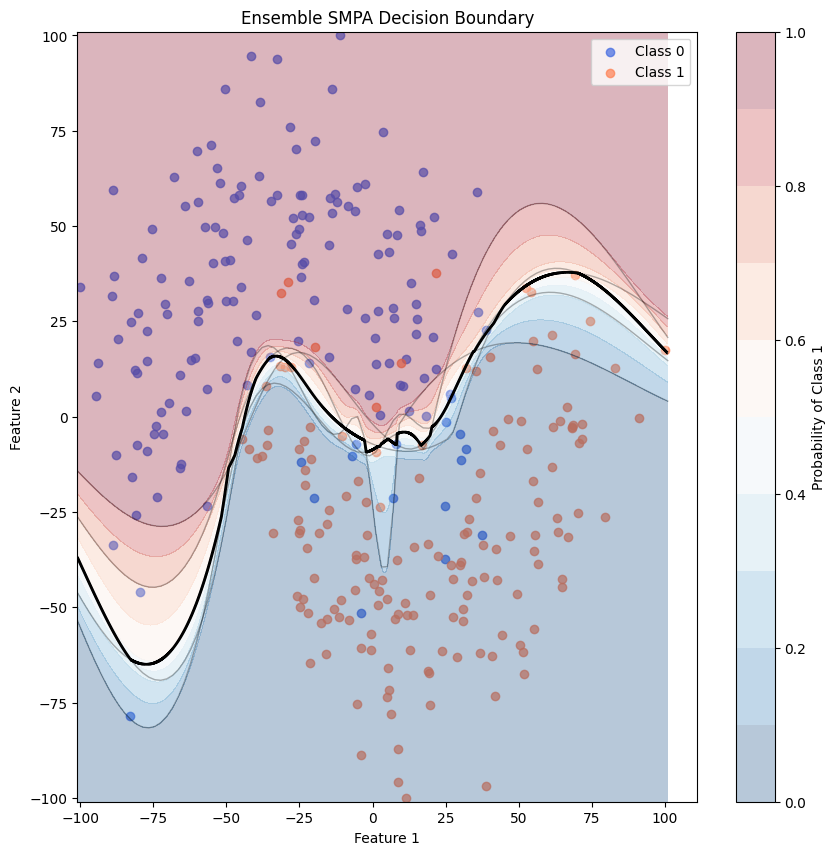

Run 0 Score: 0.8625

Run 1 for smpa...
Train Class Dist - [160 160]
Test Class Dist - [40 40]
Fitting 3 folds for each of 288 candidates, totalling 864 fits
[CV 1/3] END decay_factor=0.99, epochs=300, lambda_scaling=log, learning_rate=0.002, n_control_points=7, n_estimators=5, patience=5;, score=0.841 total time=   5.6s
[CV 2/3] END decay_factor=0.99, epochs=300, lambda_scaling=log, learning_rate=0.002, n_control_points=7, n_estimators=5, patience=10;, score=0.879 total time=   5.8s
[CV 2/3] END decay_factor=0.99, epochs=300, lambda_scaling=log, learning_rate=0.002, n_control_points=7, n_estimators=5, patience=5;, score=0.888 total time=   5.9s
[CV 1/3] END decay_factor=0.99, epochs=300, lambda_scaling=log, learning_rate=0.002, n_control_points=7, n_estimators=5, patience=10;, score=0.841 total time=   5.9s
[CV 3/3] END decay_factor=0.99, epochs=300, lambda_scaling=log, learning_rate=0.002, n_control_points=7, n_estimators=5, patience=10;, score=0.821 total time=   6.4s
[CV 3/3] END de

In [ ]:
X, y = generate_moon_dataset(n_points=400, noise=0.3)
comparison = ClassifierComparison(X, y)

# Run all classifiers on same split
classifiers = ['smpa', 'svm', 'rf', 'dt']
results = {}
for clf_type in classifiers:
    results[clf_type] = comparison.stability_test(clf_type, n_runs=5)

for clf_type, res in results.items():
    print(f"\n📊 {clf_type.upper()} Stability:")
    print(f"Mean Score: {res['mean_score']:.4f}")
    print(f"Score Std Dev: {res['std_score']:.4f}")

comparison.statistical_significance_test(results, target='smpa')